# 1D spectral extraction using aperture photometry on a point source observation
In this notebook we illustrate how to perform aperture photometry on LVL2 MRS data products (slope detector images). The algorithm is applied to a point source observation of an 800K blackbody source.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
# import modules
import funcs
from distortionMaps import d2cMapping
from shapely.geometry import Point
import shapely.affinity

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

In [2]:
# Define the paths to the data
workDir = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir  = workDir+'cdp_data/'
lvl2path  = workDir+'FM_data/LVL2/'

Given an MRS observation in a spectral band of choice, the data are reduced from LVL2 to LVL3. We do this here manually.

In [3]:
# Define filename of observation in selected MRS band
band     = '1A'
sci_file = lvl2path+'FM1T00011453/MIRFM1T00011453_1_495_SE_2011-06-03T21h10m39_LVL2.fits'
# sci_file = '/Users/ioannisa/Desktop/python/mirisim/stellar_spectra/80.50863-69.5107_22-02-18_pipeversion-jwst0.9.2/Obs1_MRS_SHORT/det_image_seq1_MIRIFUSHORT_12SHORTexp1_cal.fits'

In [4]:
# Get data
hdulist_sci   = fits.open(sci_file)
source_signal = hdulist_sci[1].data[0,:,:]

In [50]:
# load distortion map on detector plane
d2cMaps_CDP7B  = d2cMapping(band,cdpDir,slice_transmission='80pc',fileversion = "7B.05.01")
d2cMaps_CDP8B  = d2cMapping(band,cdpDir,slice_transmission='80pc',fileversion = "8B.05.00")
det_dims = (1024,1032)

<IPython.core.display.Javascript object>


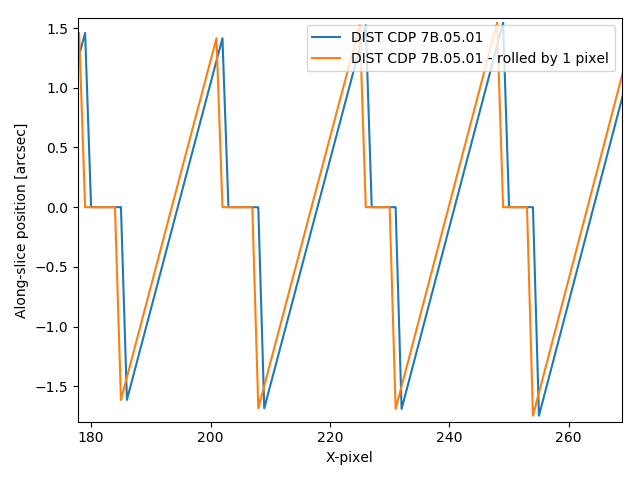

In [51]:
plt.figure()
plt.plot(d2cMaps_CDP7B['alphaMap'][512,:512],label='DIST CDP 7B.05.01')
plt.plot(d2cMaps_CDP8B['alphaMap'][512,:512],label='DIST CDP 8B.05.00')
plt.xlabel('X-pixel')
plt.ylabel('Along-slice position [arcsec]')
plt.legend()
plt.tight_layout()


In [9]:
# load CDPs
fringe_img,photom_img,pixsiz_img,psffits,specres_table,pce_table = funcs.get_cdps(band,cdpDir,output='img')

Calibration steps from LVL2 to LVL3 data include (1) background subtraction, (2) fringe correction, (3) spectrophotometric calibration.

In [10]:
# reduce LVL2 data to LVL3 data
source_signal_subtrbkg  = source_signal - 0                     # [DN/s/pix_{ij}]
source_signal_divfringe = source_signal_subtrbkg/fringe_img     # [DN/s/pix_{ij}]
source_signal_divphotom = source_signal_divfringe/photom_img    # [mJy/pix] (note here that the ij subscript has disappeared as the flat field division has changed the normalization to an average pixel area and responsivity)

To perform the 1D spectral extraction on detector level, a spectral grid is constructed using the wavelength extension of the MRS distortion maps. An aperture is defined using the spatial extension of the distortion maps.

In [11]:
# create spectral grid on detector
lambcens,lambfwhms = funcs.spectral_gridding(band,d2cMaps_CDP7B,specres_table=specres_table)

A default radius is assumed for the aperture in the case of a point source observation. That is, the default radius is the radius needed to achieve eighty-percent encircled energy on the MRS PSF. This quantity depends on wavelength, and has been pre-computed. Thus we only need to load the values.

In [12]:
eighty_percent_encircled_energy_fraction = funcs.load_obj(workDir+'notebooks/SpectralExtraction/eighty_percent_encircled_energy_fraction')
radius = np.average(eighty_percent_encircled_energy_fraction[band])

To center the aperture we need to define the centroid of the point source.

<IPython.core.display.Javascript object>


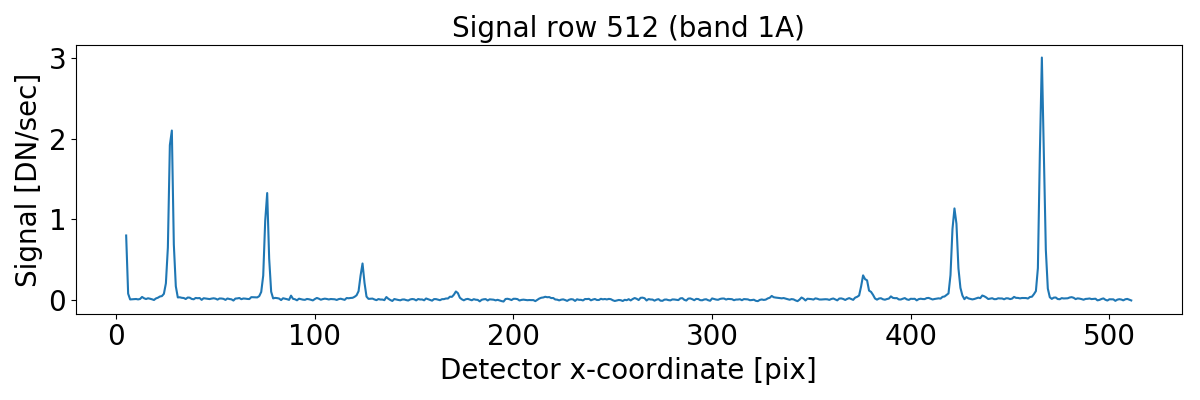

In [13]:
row=512
plt.figure(figsize=(12,4))
plt.plot(source_signal[row,:512])
plt.xlabel('Detector x-coordinate [pix]',fontsize=20)
plt.ylabel('Signal [DN/sec]',fontsize=20)
plt.tick_params(axis='both',labelsize=20)
plt.title('Signal row {} (band 1A)'.format(row),fontsize=20)
plt.tight_layout()

<IPython.core.display.Javascript object>


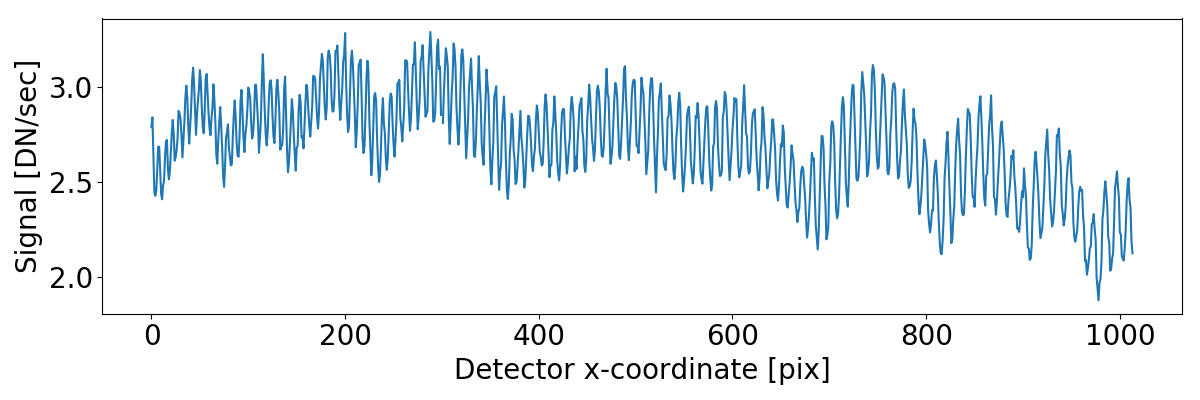

<IPython.core.display.Javascript object>


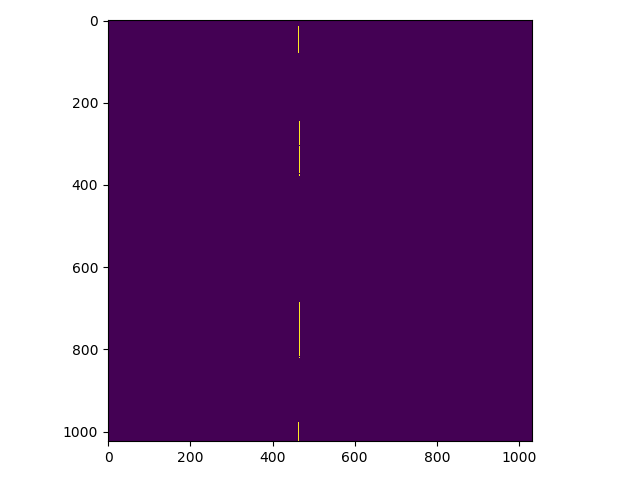

In [14]:
ypos,xpos = funcs.detpixel_trace_compactsource(source_signal,band,d2cMaps_CDP7)

plt.figure(figsize=(12,4))
plt.plot(source_signal[ypos,xpos][5:-5])
plt.xlabel('Detector x-coordinate [pix]',fontsize=20)
plt.ylabel('Signal [DN/sec]',fontsize=20)
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()

validMap = np.zeros(det_dims)
validMap[ypos,xpos] = 1

plt.figure()
plt.imshow(validMap)
plt.tight_layout()

In [47]:
fit = '2D'

if band[0] == '4':
    sign_amp,alpha_centers,beta_centers,sigma_alpha,sigma_beta,bkg_amp = funcs.point_source_centroiding(band,source_signal,d2cMaps_CDP7B,spec_grid=[lambcens,lambfwhms],fit=fit)
    if len(np.where(np.isnan(sign_amp)==True)[0]) > len(lambcens)/2:
        # too many nans.. last attempt
        sign_amp,alpha_centers,beta_centers,sigma_alpha,sigma_beta,bkg_amp = funcs.point_source_centroiding(band,source_signal,d2cMaps_CDP7B,spec_grid=[lambcens,lambfwhms],fit=fit,center=[d2cMaps_CDP7B['nslices']/2 +1,0.])
else:
    sign_amp,alpha_centers,beta_centers,sigma_alpha,sigma_beta,bkg_amp = funcs.point_source_centroiding(band,source_signal,d2cMaps_CDP7B,spec_grid=[lambcens,lambfwhms],fit=fit)

source_alpha_center = np.mean(alpha_centers[~np.isnan(alpha_centers)])
source_beta_center  = np.mean(beta_centers[~np.isnan(beta_centers)])

alpha_centers_CDP7B = alpha_centers.copy()

STEP 1: Rough centroiding
Slice 12 has the largest summed flux
Source position: beta = 0.18arcsec, alpha = 0.02arcsec 

STEP 2: 1D Gaussian fit
[Along-slice fit] The following bins failed to converge:
[0, 323, 328, 332, 336, 341, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597]
[Across-slice fit] The following bins failed to converge:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 46, 47, 48, 49, 52, 53, 54, 55, 56, 57, 61, 62, 63, 64, 65, 66, 73, 74, 75, 76, 77, 78, 85, 86, 87, 88, 90, 91, 92, 93, 94, 95, 99, 100, 101, 102, 103, 104, 106, 107, 108, 109, 110, 111, 113, 114, 115, 116, 118, 119, 120, 121, 125, 126, 127, 128, 130, 131, 132, 133, 135, 136, 137, 138, 142, 143, 145, 146, 147, 148, 150, 151, 155, 156, 158, 159, 160, 161, 163, 164, 166, 167, 168, 169, 171, 172, 174, 175, 176, 177, 179, 180, 182, 183, 185, 186, 191, 192, 193, 194, 196, 197, 199, 200, 202, 203, 204, 205, 221, 222, 227, 228, 229, 230, 232, 233,

In [48]:
fit = '2D'

if band[0] == '4':
    sign_amp,alpha_centers,beta_centers,sigma_alpha,sigma_beta,bkg_amp = funcs.point_source_centroiding(band,source_signal,d2cMaps_CDP8B,spec_grid=[lambcens,lambfwhms],fit=fit)
    if len(np.where(np.isnan(sign_amp)==True)[0]) > len(lambcens)/2:
        # too many nans.. last attempt
        sign_amp,alpha_centers,beta_centers,sigma_alpha,sigma_beta,bkg_amp = funcs.point_source_centroiding(band,source_signal,d2cMaps_CDP8B,spec_grid=[lambcens,lambfwhms],fit=fit,center=[d2cMaps_CDP8B['nslices']/2 +1,0.])
else:
    sign_amp,alpha_centers,beta_centers,sigma_alpha,sigma_beta,bkg_amp = funcs.point_source_centroiding(band,source_signal,d2cMaps_CDP8B,spec_grid=[lambcens,lambfwhms],fit=fit)

source_alpha_center = np.mean(alpha_centers[~np.isnan(alpha_centers)])
source_beta_center  = np.mean(beta_centers[~np.isnan(beta_centers)])

alpha_centers_CDP8B = alpha_centers.copy()

STEP 1: Rough centroiding
Slice 12 has the largest summed flux
Source position: beta = 0.18arcsec, alpha = -0.05arcsec 

STEP 2: 1D Gaussian fit
[Along-slice fit] The following bins failed to converge:
[0, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597]
[Across-slice fit] The following bins failed to converge:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597]

STEP 3: 2D Gaussian fit
The following bins failed to converge:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 38, 39, 40, 42, 120, 121, 122, 196, 202, 294, 295, 303, 304, 305, 344, 345, 346, 347, 370, 371, 372, 373, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597]


<IPython.core.display.Javascript object>


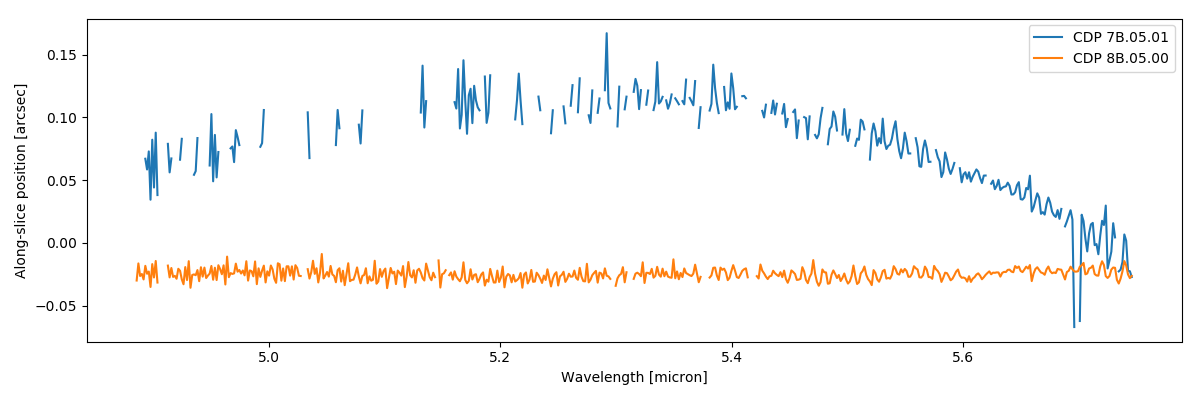

In [49]:
plt.figure(figsize=(12,4))
plt.plot(lambcens,alpha_centers_CDP7B,label='CDP 7B.05.01')
plt.plot(lambcens,alpha_centers_CDP8B,label='CDP 8B.05.00')
plt.xlabel('Wavelength [micron]')
plt.ylabel('Along-slice position [arcsec]')
plt.legend()
plt.tight_layout()

In [22]:
# define aperture shape
# 1st elem = center point (x,y) coordinates
# 2nd elem = the two semi-axis values (along x, along y)
# 3rd elem = angle in degrees between x-axis of the Cartesian base
#            and the corresponding semi-axis
if (np.isnan(source_alpha_center)) or (np.isnan(source_beta_center) is True):
    raise 'Invalid centroid! Center is NaN!'
ellipse = ((source_alpha_center, source_beta_center),(1,1),0)

# Let create a circle of radius 1 around center point:
circ = shapely.geometry.Point(ellipse[0]).buffer(radius)

# Let create the ellipse along x and y:
ell  = shapely.affinity.scale(circ, int(ellipse[1][0]), int(ellipse[1][1]))

# Let rotate the ellipse (clockwise, x axis pointing right):
ellr = shapely.affinity.rotate(ell,ellipse[2])

# save final output as the aperture and calculate the aperture area
aperture = ellr
aperture_area = aperture.area

Each pixel on the detector has a fractional area overlap with the defined aperture. This percentage is used to weigh the signal contribution of a pixel to the total flux of the source in any given spectral bin.

In [23]:
# create weight map with the pixel signal contributions (percentage area overlap with defined aperture)
weight_map = funcs.pixel_signal_contribution(d2cMaps,aperture,spec_grid=[lambcens,lambfwhms])

Pixel weight mapping
0/599 bins processed
100/599 bins processed
200/599 bins processed
300/599 bins processed
400/599 bins processed
500/599 bins processed
599/599 bins processed


Aperture extraction is performed in each spectral bin by multiplying the signal of the contributing pixels by their respective weights. The signals are then summed.

In [24]:
# perform 1d aperture extraction
aperture_extracted_signal = funcs.aperture_weighted_photometry_point_source(source_signal,weight_map,d2cMaps,spec_grid=[lambcens,lambfwhms])

In [25]:
unique_betas = np.sort(np.unique(d2cMaps['betaMap'][(d2cMaps['sliceMap']>100*int(band[0])) & (d2cMaps['sliceMap']<100*(int(band[0])+1))]))
    
norm_factor,spatial_sum,fov_bin = [np.zeros(len(lambcens)) for i in range(3)]
for ibin in range(len(lambcens)):
    pixelsInBin = (np.abs(d2cMaps['lambdaMap']-lambcens[ibin])<lambfwhms[ibin]/2.)
    fov_lims = [d2cMaps['alphaMap'][pixelsInBin].min(),d2cMaps['alphaMap'][pixelsInBin].max()]
    fov_bin[ibin]  = (unique_betas.max()-unique_betas.min())*(fov_lims[1]-fov_lims[0])
    spatial_sum[ibin] = pixsiz_img[pixelsInBin].sum()
    norm_factor[ibin] = (spatial_sum[ibin]/fov_bin[ibin])

In [26]:
# aperture correction based on 80% encircled energy fraction radius
aperture_correction = 1.2

In [28]:
# normalize aperture extracted signal
aperture_extracted_signal = aperture_extracted_signal * aperture_correction / norm_factor

Let's plot the extracted 1D spectrum.

<IPython.core.display.Javascript object>


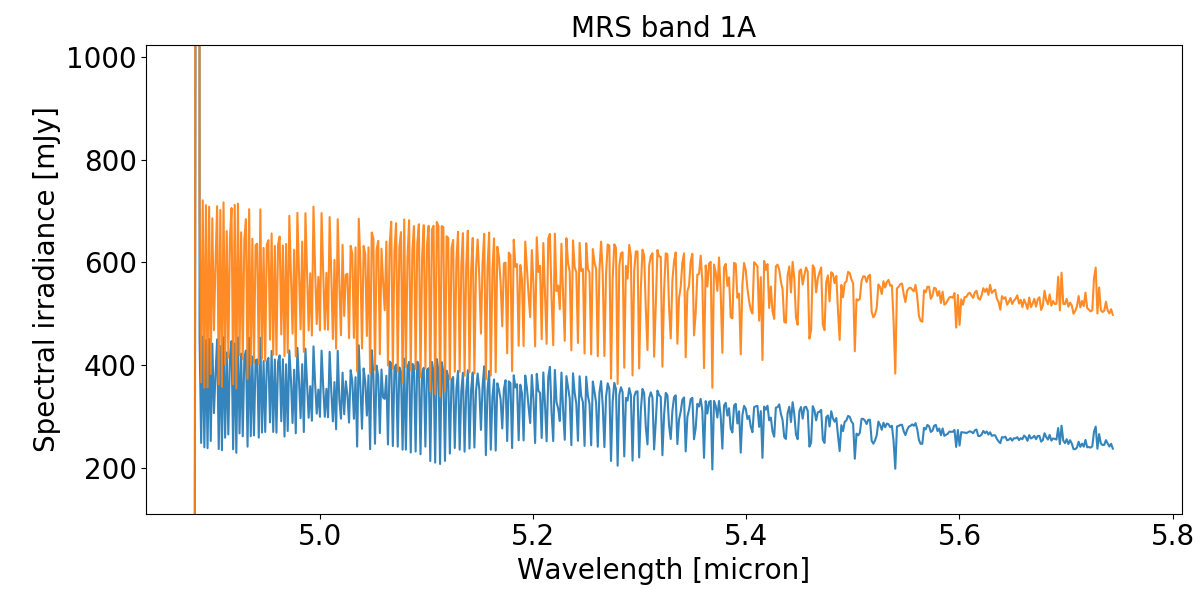

In [29]:
# plot extracted spectrum
plt.figure(figsize=(12,6))
plt.plot(lambcens[20:-20],aperture_extracted_signal[20:-20],alpha=0.9)
plt.plot(lambcens[20:-20],(aperture_extracted_signal*norm_factor)[20:-20],alpha=0.9)
plt.xlabel('Wavelength [micron]',fontsize=20)
plt.ylabel(r'Spectral irradiance [mJy]',fontsize=20)
plt.title('MRS band {}'.format(band),fontsize=20)
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()